In [106]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [1]:
#default_exp gen

In [107]:
#exporti
from __future__ import annotations

from PIL import Image, ImageDraw, ImageFont
from functools import cached_property, lru_cache, wraps
from contextlib import contextmanager
from pathlib import Path
from typing import Literal, Tuple, Dict, List, Union, Any, Generator, Generic, TypeVar, Set, Callable
import attr
import matplotlib.pyplot as plt
import numpy as np
import pdb
import random
import orjson

T = TypeVar('T')

Gen = Generator[T, None, None]

In [108]:
#exporti
# https://stackoverflow.com/questions/9733288/how-to-programmatically-calculate-the-contrast-ratio-between-two-colors
def color_luminance(v: float) -> float:
    # only if these are [0, 255]
    # v /= 255
    return v / 12.92 if v <= 0.03928 else pow((v + 0.055) / 1.055, 2.4)  

def luminance(col: Tuple[float, float, float]) -> float:
    r, g, b = col
    return color_luminance(r) * 0.2126 + color_luminance(g) * 0.7152 + color_luminance(b) * 0.0722


from matplotlib import colors as pltcolors
def colors_min_contrast(contrast_min: float) -> Gen[Color]:
    for c1 in set(pltcolors.CSS4_COLORS.values()):
        for c2 in set(pltcolors.CSS4_COLORS.values()):
            if c1 == c2:
                continue
            col = Color(c1, c2)
            if col.contrast >= contrast_min:
                yield col
                
# list(colors_min_contrast(4.0))

def normalize_wts(wts: List[float]) -> List[float]:
    s = sum(wts)
    return [w/s for w in wts]


In [109]:
@attr.s
class Font:
    fontfile = attr.ib(type=Fontfile)
    size = attr.ib(type=int)

    @cached_property
    def imagefont(self) -> ImageFont:
        return ImageFont.truetype(str(self.fontfile.path), self.size)


@attr.s
class Color:
    bgcolor = attr.ib(type=str)
    fgcolor = attr.ib(type=str)

    @cached_property
    def contrast(self) -> float:
        # contrast((255, 255, 255), (255, 255, 0)) # 1.074 for yellow
        # contrast((255, 255, 255), (0, 0, 255))   # 8.592 for blue
        # minimal recommended contrast ratio is 4.5, or 3 for larger font-sizes

        lum_a = self.bgluminance 
        lum_b = self.fgluminance
        return ((max(lum_a, lum_b) + 0.05) / (min(lum_a, lum_b) + 0.05))

    @property
    def bgluminance(self) -> float:
        return luminance(pltcolors.to_rgb(self.bgcolor))

    @property
    def fgluminance(self) -> float:
        return luminance(pltcolors.to_rgb(self.fgcolor))

    @cached_property
    def weight(self) -> float:
        return self.contrast

def make_segmask(img: Image) -> Segmask:
    return np.zeros(img_npsize(img), dtype=np.uint8)

@contextmanager
def new_image_with_mask(file=None, *args, **kwargs) -> Generator[Tuple[Image, Segmask], None, None]:
    img = Image.new(*args, **kwargs)
    yield img, make_segmask(img)
    if file is not None:
        img.save(file)
    

@contextmanager
def crop(img: Image, segmask: Segmask, margins: Tuple[float, float, int, int]) -> Generator[Tuple[ImageDraw, Segmask], None, None]:
    width, height = img.size
    left, top, right, bottom = margins
    
    cropped = img.crop((left, top, width - right, height - bottom))
    cropped_segmask = make_segmask(cropped)
    
    yield ImageDraw.Draw(cropped), cropped_segmask
    
    img.paste(cropped, (margins[0], margins[1]))
    segmask[top:(height-bottom), left:(width-right)] = cropped_segmask




In [110]:
#exporti

def fix_fig_spacing(fig, title_pct: float = 0.0):
    fig.subplots_adjust(left=0,right=1,bottom=0,top=(1 - title_pct),wspace=0,hspace=0)

def img_npsize(img) -> Tuple[int, int]:
    return tuple(reversed(img.size))

In [110]:
#export
def show_npimg(npimg, dpi=96, cmap='gray', ax=None, figsize=None, has_title=False):
    if ax is None:        
        figsize = (npimg.shape[0]/dpi, npimg.shape[1]/dpi) if figsize is None else figsize
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
        fix_fig_spacing(fig, title_pct=(0.05 if has_title else 0))
    ax.set_axis_off()
    ax.imshow(npimg, cmap=cmap, interpolation='none') 
    
def show_img(img: Image, *args, **kwargs):
    show_npimg(np.array(img), *args, **kwargs)
    

In [111]:
#exporti

def weighted_choice(choices: List[T], weights: Union[List[float], None] = None) -> T:
    return random.choices(choices, weights=weights, k=1)[0]


def chunker(txt: str, chunksize: int) -> Gen[str]:
    i = 0
    while i < len(txt):
        yield txt[i:i+chunksize]
        i += chunksize

def chunk(gen_txt: Gen[str], chunksize: int) -> Gen[str]:
    curr = ''
    while True:
        while len(curr) < chunksize:
            curr = curr + ' ' + next(gen_txt)
        yield from chunker(curr, chunksize)
        curr = ''
        
   
import re
def vocab() -> List[char]:
    # excludes space
    return [chr(i) for i in range(33, 127)]

# print("Vocab size:", len(vocab()) + 1)

# !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~
# includes a space (chr(32))
NOT_VOCAB_RE = re.compile(f'[^\s{re.escape("".join(vocab()))}]')
LINESPLIT_RE = re.compile(r'[\r\n\t\s]')

def remove_linesplits(s: str) -> str:
    return LINESPLIT_RE.sub(' ', s)

def filter_to_vocab(s: str) -> str:
    return NOT_VOCAB_RE.sub('', s)
     
def char_to_code(c: str) -> int:
    # 32 is space, but we don't create bboxes or masks for that
    # 33 will get 1
    # 0 will be backgrounds
    return ord(c) - 32

def text_choice(col: pd.Series) -> str:
    return filter_to_vocab(remove_linesplits(random.choice(col)))

def coroutine(gen: Gen) -> Gen:
    """
    Starts the generator so that you can call .send() on it
    """
    @wraps(gen)
    def start(*args, **kwargs):
        cr = gen(*args, **kwargs)
        next(cr)
        return cr
    return start

@coroutine
def gen_choice(chooser: Callable[[], T], switch_prob: float) -> Gen[T]:
    current: Union[T, None] = None
    one_time_switch_prob: Union[float, None] = None
    while True:
        if current is None or random.random() <= (one_time_switch_prob or switch_prob):
            current = chooser()
        one_time_switch_prob = yield current



Vocab size: 95


In [112]:
#exporti

def get_color_gen(min_contrast=10.0, switch_prob=0.5) -> Gen[Color]:
    choices = list(colors_min_contrast(min_contrast))
    weights = [col.weight for col in choices]
    return gen_choice(lambda: weighted_choice(choices, normalize_wts(weights)), switch_prob=switch_prob)

# colors = get_color_choices(switch_prob=1.0)
# [next(colors) for i in range(10)]

In [163]:
#exporti

Align = Literal['left', 'right', 'center']

def raw_charmask(c: str, font: ImageFont) -> np.ndarray:
    mask = font.getmask(c)
    npmask = np.uint8(np.resize(np.array(mask), img_npsize(mask)))
    return npmask

@lru_cache(maxsize=None)
def charmask(c: str, font: ImageFont, thresh: (float, float) = (1, 0.5)) -> np.ndarray:
    npmask = raw_charmask(c, font)
    if thresh and c != ' ':
        mean, std = npmask.mean(), npmask.std()
        npmask[npmask <= mean * thresh[0] + std * thresh[1]] = 0
    npmask[npmask > 0] = char_to_code(c)
    return npmask

def left_align_layout_text(txt: str, font: ImageFont, width: int, overflow: bool) -> Tuple[str, int]:
    fitchars = []
    curr_x = 0
    for c in txt:
        if curr_x > width:
            break
        new_x = curr_x + charmask(c, font).shape[1]
        if new_x > width and not overflow:
            break
        fitchars.append(c)
        curr_x = new_x
            
    return (''.join(fitchars), 0)


def right_align_layout_text(txt: str, font: ImageFont, width: int, overflow: bool) -> Tuple[str, int]:
    fitchars = []
    curr_x = width
    for c in reversed(txt):
        if curr_x < 0:
            break
        new_x = curr_x - charmask(c, font).shape[1]
        if new_x < 0 and not overflow:
            break
        fitchars.append(c)
        curr_x = new_x
            
    return (''.join(reversed(fitchars)), curr_x)    


def center_align_layout_text(txt: str, font: ImageFont, width: int, overflow: bool) -> Tuple[str, int]:    
    txtlen = len(txt)
    halflen = txtlen // 2
    is_even = (halflen == txtlen / 2.0)
    
    left_segment, right_segment = txt[:halflen], txt[halflen:]
    middlechar_wd = charmask(right_segment[0], font).shape[1]
    width_adj = 0 if is_even else middlechar_wd
    
    right_trunc, right_start_pos = left_align_layout_text(right_segment, font, width // 2 - width_adj, overflow = overflow)
    left_trunc, left_start_pos = right_align_layout_text(left_segment, font, width // 2 + width_adj, overflow = overflow)
    
    return (left_trunc + right_trunc, left_start_pos)
     
    
def layout_text(txt: str, font: ImageFont, width: int, align: Align, overflow: bool) -> Tuple[str, int]:
    if align == 'left':
        return left_align_layout_text(txt, font, width, overflow)
    elif align == 'right':
        return right_align_layout_text(txt, font, width, overflow)
    elif align == 'center':
        return center_align_layout_text(txt, font, width, overflow)
    else:
        raise NotImplementedError()

 
Box = Tuple[float, float, int, int]
Coord = Tuple[int, int]
BoundingBox = Tuple[str, Box]
Segmask = np.ndarray

def split_words(txt: str) -> Gen[str]:
    for w in re.split('\s+', txt):
        yield w + ' '

from math import ceil
def find_fit_length(width: int, font: ImageFont, try_count: int = 300) -> int:
    try_string = ''.join(chr(i) for i in random.choices(range(0, 255), k=try_count))
    try_width, _ = font.getsize(try_string)
    return ceil((width / try_width) * try_count)


from itertools import groupby
def line_with_mask(draw: ImageDraw, segmask: Segmask, txt: str, font: ImageFont, color: Gen[Color], y: int, bgcolor: str, overflow: bool, align: Align, draw_bboxes: bool, bgpadding: int = 2) -> Tuple[List[BoundingBox], int]:
    img_wd, img_ht = draw.im.size
    trunc_txt, curr_x = layout_text(txt, font=font, width=img_wd, align=align, overflow=overflow)

    bboxes = []
    new_y = y

    # we group words by bgcolor so that we can do a single fill for it
    words_with_colors = [(w, next(color)) for w in split_words(trunc_txt)]
    for phrase_color, phrase_group in groupby(words_with_colors, lambda _: _[1]):
        phrase = ''.join([w for w, _ in phrase_group])
        if phrase_color.bgcolor != bgcolor:
            phrase_wd, phrase_ht = draw.textsize(phrase, font=font) 
            draw.rectangle((curr_x - bgpadding, y - bgpadding, curr_x + phrase_wd + bgpadding, y + phrase_ht + bgpadding), fill=phrase_color.bgcolor, outline=None)

        # drawing the whole phrase at once will have mismatches with the charmasks and the bboxes
        # draw.text((curr_x, y), phrase, font=font, fill=phrase_color.fgcolor)            
        for c in phrase:
            # But this might lead to issues with kerning and so on - hopefully the model will become robust to this
            draw.text((curr_x, y), c, font=font, fill=phrase_color.fgcolor)
            
            # the rendered char, including space above it in the line
            render_wd, render_ht = font.getsize(c)

            # No mask/bbox for whitespace chars
            if c != ' ':
                cmask = charmask(c, font)
                cmask_ht, cmask_wd = cmask.shape

                char_start_x, char_start_y = curr_x + render_wd - cmask_wd, y + render_ht - cmask_ht
                char_end_x, char_end_y = char_start_x + cmask_wd, char_start_y + cmask_ht

                # these are numpy coords (similar to segmask)
                bboxes.append((c, (char_start_y, char_start_x, char_end_y, char_end_x)))
                if draw_bboxes:
                    draw.rectangle((char_start_x, char_start_y, char_end_x, char_end_y), fill=None, outline='gray')

                # handle off-edge by slicing cmask to match region dims
                region = segmask[char_start_y:char_end_y, char_start_x:char_end_x]      
                segmask[char_start_y:char_end_y, char_start_x:char_end_x] = cmask[:region.shape[0], :region.shape[1]]

            curr_x += render_wd
            new_y = max(new_y, y + render_ht)

    return bboxes, new_y


def _choose_next_font(fontfile: Gen[Fontfile], fontsize: Gen[int]) -> Union[ImageFont, None]:
    try:
        ff = next(fontfile)
        fs = next(fontsize)
        fnt = Font(ff, fs).imagefont
        fnt.getsize('foo')
    except OSError:
        print(f'Font getsize failed {ff.name} {fs}')
        return None
    else:
        return fnt

def choose_next_font(fontfile: Gen[Fontfile], fontsize: Gen[int]) -> ImageFont:
    while True:
        fnt = _choose_next_font(fontfile, fontsize)
        if fnt is not None:
            return fnt
 
def text_with_mask(draw: ImageDraw, segmask: Segmask, fontfile: Gen[Fontfile], fontsize: Gen[int], color: Gen[Color], text: Gen[str], linespacing: int, bgcolor: str, align: Align, overflow: bool, draw_bboxes: bool) -> Tuple[Segmask, List[List[BoundingBox]]]:
    y: int = 0
    bboxes: List[List[BoundingBox]] = []
    img_wd, img_ht = draw.im.size

    # pick a rough chunksize for this image
    font = choose_next_font(fontfile, fontsize)
    chunksize = find_fit_length(img_wd, font)    
    for l in chunk(text, chunksize):
        if len(l):
            _, line_height = font.getsize(l)
            if y + line_height > img_ht:
                break
            line_bboxes, y = line_with_mask(draw, segmask, l, font, color, y, bgcolor=bgcolor, overflow=overflow, align=align, draw_bboxes=draw_bboxes)
            bboxes.append(line_bboxes)
            
            # We won't switch fonts/fontsize within a line
            font = choose_next_font(fontfile, fontsize)
        y += linespacing
    return bboxes

def save_mask(mask: Segmask, filename: str):
    Image.frombuffer(mode='L', size=mask.shape, data=mask).save(filename)

In [163]:
#export
#@profiler
def make_image(output_dir: Path, basename: str, size: Coord, margins: Box, fontfile: Gen[Fontfile], color: Gen[Color], fontsize: Gen[int], text: Gen[str], draw_bboxes: bool = False):
    # force these to be different for a new image
    fontfile.send(1.0)
    fontsize.send(1.0)
    color.send(1.0)
    
    bgcolor = next(color).bgcolor
    with new_image_with_mask(file=output_dir / 'images' /  f'{basename}.png', mode='RGB', size=size, color=bgcolor) as (img, segmask):
        with crop(img, segmask, margins) as (draw, cropmask):
            bboxes = text_with_mask(draw, cropmask, fontfile=fontfile, fontsize=fontsize, color=color, text=text, linespacing=10, bgcolor=bgcolor, align='left', overflow=False, draw_bboxes=draw_bboxes)
    save_mask(segmask, output_dir / 'masks' / f'{basename}.png') 
    (output_dir / 'bboxes' / f'{basename}.json').write_bytes(orjson.dumps(bboxes))
    

# Fonts

In [17]:
# !pip install protobuf
# !curl -O 'https://raw.githubusercontent.com/googlefonts/gftools/master/Lib/gftools/fonts_public_pb2.py'

In [18]:
# !mkdir -p fonts/google corpora
# !curl -L https://github.com/google/fonts/archive/master.zip -o fonts/google/google-fonts.zip
# !cd fonts/google/ && unzip google-fonts.zip

In [114]:
#exporti

FONTS_DIR = Path('fonts/google/fonts-master')

import os
from google.protobuf import text_format, json_format
import fonts_public_pb2    

@attr.s(auto_attribs=True)
class Fontfile:
    name: str
    style: str
    category: str
    fontweight: int
    path: Path

    @property
    def weight(self) -> float:
        if self.fontweight != 400:
            return 1.0
        if self.style != 'normal':
            return 1.0
        return 3.0

    @property
    def is_blacklisted(self) -> bool:
        # errors on .getsize()
        return self.name.startswith('Rubik')

def get_fontfiles(required_subsets: Set[str] = {'latin'}, filter_categories: Set[str] = {'DISPLAY', 'HANDWRITING'}) -> Gen[Fontfile]:
    for dirname, dirs, files in os.walk(FONTS_DIR):
        if 'METADATA.pb' not in files:
            continue
        dir = Path(dirname)
        metadata = parse_metadata_pb( dir / 'METADATA.pb')
        if not len(set(metadata['subsets']) & required_subsets):
            continue
        if metadata['category'] in filter_categories:
            continue
        for font in metadata['fonts']:
            ff = Fontfile(font['fullName'], font['style'], metadata['category'], font['weight'], dir/font['filename'])
            if not ff.is_blacklisted:
                yield ff

            
def get_fontfile_gen(switch_prob=1.0) -> Gen[Fontfile]:
    fontfiles = list(get_fontfiles())
    weights = [f.weight for f in fontfiles]
    return gen_choice(lambda: weighted_choice(fontfiles, weights), switch_prob=switch_prob)
            
def parse_metadata_pb(pbfile: Path) -> Dict:
    font_family = fonts_public_pb2.FamilyProto()
    text_format.Merge(pbfile.read_text(), font_family)
    return json_format.MessageToDict(font_family)    
    
    
# list(os.walk(fonts_dir))

# Corpora

In [20]:
# !kaggle datasets download jrobischon/wikipedia-movie-plots 
# !unzip corpora/wikipedia-movie-plots.zip -d corpora
# !ls corpora


In [115]:
import pandas as pd
# wp_plots.to_feather('corpora/wp_plots.feather')

# Generation

In [165]:
# def make_image(output_dir: Path, basename: str, size: Coord, margins: Box, fontfile: Gen[Fontfile], color: Gen[Color], fontsize: Gen[int], text: Gen[str]):


# Can we threshold charmasks?

In [144]:
from fastai2.vision.data import get_grid

fnt = Font(fontfile_gen.send(1.0), 20)
fnt.fontfile.name

def draw_charmasks(fnt):
    voc = vocab()
    fig, axs = get_grid(len(voc) * 2, nrows=2, return_fig=True, imsize=1, title=(''.join(voc)))
    fix_fig_spacing(fig, title_pct=0.2)
    for i, c in enumerate(voc):
        cm = raw_charmask(c, fnt.imagefont)
        show_npimg(cm, ax=axs[i])
        cm_mean, cm_std = cm.mean(), cm.std()
        cm[cm <= cm_mean + cm_std * 0.5] = 0
        cm[cm > 0] = ord(c)
        show_npimg(cm, ax=axs[i + len(voc)])
        
#print(''.join(vocab()))
#draw_charmasks(fnt)

'Mohave Light Italic'

array([[ 0,  0,  0, 67, 67, 67, 67,  0,  0],
       [ 0,  0, 67, 67,  0,  0, 67, 67,  0],
       [ 0,  0, 67,  0,  0,  0,  0, 67,  0],
       [ 0, 67, 67,  0,  0,  0,  0, 67,  0],
       [ 0, 67, 67,  0,  0,  0,  0,  0,  0],
       [ 0, 67,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 67,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 67,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 67,  0,  0,  0,  0, 67, 67,  0],
       [ 0, 67, 67,  0,  0,  0, 67,  0,  0],
       [ 0,  0, 67, 67, 67, 67,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=uint8)

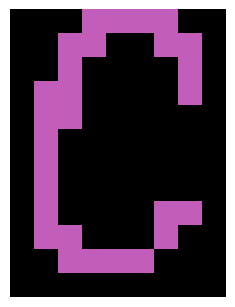

In [164]:
charmask('c', fnt.imagefont)
show_npimg(charmask('c', fnt.imagefont), figsize=(3,3), cmap=glasbey_cm)

In [151]:
# export

# !pip install colorcet

import colorcet as cc
import matplotlib as mp
glasbey_cm = mp.colors.ListedColormap(['black'] + cc.glasbey_dark[:96])

In [160]:
#exporti
# !pip install tqdm

from multiprocessing import Pool
from tqdm import tqdm

def make_one_image(i: int):
    make_image(output_dir, basename=str(i), size=(300, 300), margins=(10, 10, 10, 10), fontfile=fontfile_gen, color=color_gen, fontsize=fontsize_gen, text=text_gen, draw_bboxes=False)

output_dir = Path('./outputs')
output_images_dir = output_dir / 'images'
output_masks_dir = output_dir / 'masks'
output_bboxes_dir = output_dir / 'bboxes'

def show_random_image(n: int):
    basename=str(random.choice(range(n)))
    im = Image.open(output_images_dir / f'{basename}.png')
    segmask = Image.open(output_masks_dir / f'{basename}.png')
    # bboxes = orjson.loads(Path(f'./outputs/{basename}.bboxes.json').read_bytes())
    show_img(im), show_img(segmask, cmap=glasbey_cm, figsize=(6, 6))

def make_n_images(n: int):
    # random.seed(4)
    wp_plots = pd.read_csv('./corpora/wiki_movie_plots_deduped.csv')[['Plot']]
    fontfile_gen = get_fontfile_gen(switch_prob=0.1)
    color_gen = get_color_gen(min_contrast=4.0, switch_prob=0.05)
    fontsize_gen = gen_choice(lambda: weighted_choice(range(9, 18)), switch_prob=0.1)
    text_gen = gen_choice(lambda: text_choice(wp_plots['Plot']), switch_prob=1.0)

    for d in [output_images_dir, output_bboxes_dir, output_masks_dir]:
        d.mkdir(parents=True, exist_ok=True)
        
    with Pool() as p:
        for _ in tqdm(p.imap_unordered(make_one_image, range(n)), total=n):
            pass



In [166]:
n_images = 10_000
make_n_images(n_images)

  8%|▊         | 811/10000 [00:39<06:59, 21.90it/s]<ipython-input-163-787449f4fe4f>:12: RuntimeWarning: Mean of empty slice.
  mean, std = npmask.mean(), npmask.std()
 16%|█▌        | 1588/10000 [01:15<06:54, 20.30it/s]<ipython-input-163-787449f4fe4f>:12: RuntimeWarning: Mean of empty slice.
  mean, std = npmask.mean(), npmask.std()
 18%|█▊        | 1792/10000 [01:25<05:19, 25.71it/s]<ipython-input-163-787449f4fe4f>:12: RuntimeWarning: Mean of empty slice.
  mean, std = npmask.mean(), npmask.std()
 69%|██████▉   | 6940/10000 [05:37<02:28, 20.62it/s]<ipython-input-163-787449f4fe4f>:12: RuntimeWarning: Mean of empty slice.
  mean, std = npmask.mean(), npmask.std()
 69%|██████▉   | 6944/10000 [05:37<02:10, 23.44it/s]<ipython-input-163-787449f4fe4f>:12: RuntimeWarning: Mean of empty slice.
  mean, std = npmask.mean(), npmask.std()
100%|██████████| 10000/10000 [08:06<00:00, 20.55it/s]


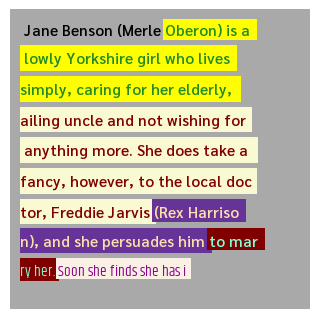

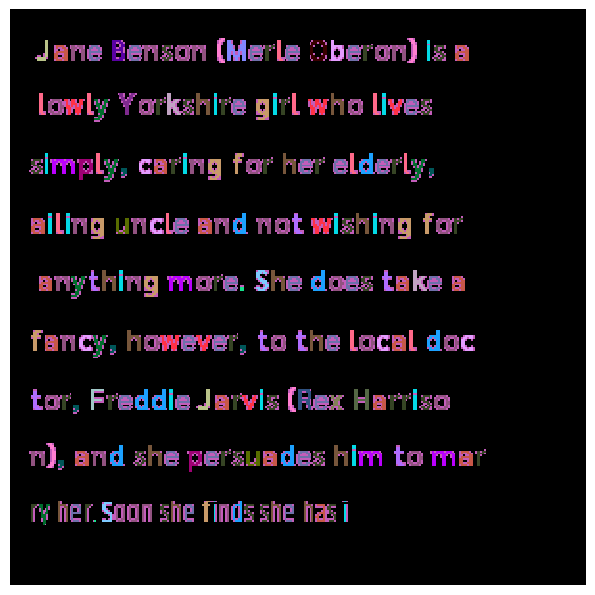

In [161]:
show_random_image(n_images)

In [128]:
#exporti

def demo_color_contrast():
    fnt = Font(next(fontfile_gen).path, 12).imagefont    
    colors = sorted(colors_min_contrast(4.0), key=lambda c: c.contrast)
    from math import sqrt

    colors = np.array(colors)
    colors = np.resize(colors, (62, 62))
    colors.shape

    cellsize=15
    with new_image_with_mask(mode='RGB', size=(62 * cellsize, 62 * cellsize)) as (img, _):
        draw = ImageDraw.Draw(img)    
        for i in range(62):
            for j in range(62):
                draw.rectangle((i * cellsize, j * cellsize, (i + 1) * cellsize, (j+1)*cellsize), fill=colors[i][j].bgcolor)
                draw.text((i * cellsize, j * cellsize), str(int(colors[i][j].contrast)), fill=colors[i][j].fgcolor, font=fnt)
            
    show_img(img, figsize=(12, 12))

In [25]:
# import cProfile
# def profiler(func):
#     def wrapper(*args, **kwargs):
#         with cProfile.Profile() as pr:
#             result = func(*args, **kwargs)
#         return (result, pr)
#     return wrapper

# import pstats
# pstats.Stats(pr).sort_stats('tottime').print_stats()

In [7]:
from nbdev.export import *
notebook2script()

Converted gen.ipynb.
Converted unet.ipynb.
